In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [22]:
#Import test & training dataset
train_file_path = "../Data/partial_data.csv"
test_file_path = "../Data/test.csv" 

#convert datasets to pandas dataframe
train_df = pd.read_csv(train_file_path)
test_df = pd.read_csv(test_file_path)
train_df.columns = train_df.columns.str.strip()
test_df.columns = test_df.columns.str.strip()
#Print info on dataframe
print(train_df.head())
print(test_df.head())
print(train_df.info())
print(test_df.info())
print(train_df.describe())
print(test_df.describe())



          id  vendor_id      pickup_datetime     dropoff_datetime  \
0  id2875421          2  2016-03-14 17:24:55  2016-03-14 17:32:30   
1  id2377394          1  2016-06-12 00:43:35  2016-06-12 00:54:38   
2  id3858529          2  2016-01-19 11:35:24  2016-01-19 12:10:48   
3  id3504673          2  2016-04-06 19:32:31  2016-04-06 19:39:40   
4  id2181028          2  2016-03-26 13:30:55  2016-03-26 13:38:10   

   passenger_count  pickup_longitude  pickup_latitude  dropoff_longitude  \
0                1        -73.982155        40.767937         -73.964630   
1                1        -73.980415        40.738564         -73.999481   
2                1        -73.979027        40.763939         -74.005333   
3                1        -74.010040        40.719971         -74.012268   
4                1        -73.973053        40.793209         -73.972923   

   dropoff_latitude store_and_fwd_flag  trip_duration  
0         40.765602                  N            455  
1         40.731

In [23]:

def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Radius of the Earth in km
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    return R * c




In [24]:
train_df = train_df.dropna() #Drop missing/empty values
test_df = test_df.dropna()

In [25]:
train_df['pickup_datetime'] = pd.to_datetime(train_df['pickup_datetime'])
train_df['pickup_minute'] = train_df['pickup_datetime'].dt.minute
train_df['pickup_second'] = train_df['pickup_datetime'].dt.second
train_df['pickup_hour'] = train_df['pickup_datetime'].dt.hour
train_df['pickup_day'] = train_df['pickup_datetime'].dt.day
train_df['pickup_month'] = train_df['pickup_datetime'].dt.month
train_df['pickup_weekday'] = train_df['pickup_datetime'].dt.weekday
train_df['haversine_distance'] = haversine(
    train_df['pickup_latitude'], train_df['pickup_longitude'],
    train_df['dropoff_latitude'], train_df['dropoff_longitude']
)

In [26]:
test_df['pickup_datetime'] = pd.to_datetime(test_df['pickup_datetime'])
test_df['pickup_minute'] = test_df['pickup_datetime'].dt.minute
test_df['pickup_second'] = test_df['pickup_datetime'].dt.second 
test_df['pickup_hour'] = test_df['pickup_datetime'].dt.hour
test_df['pickup_day'] = test_df['pickup_datetime'].dt.day
test_df['pickup_month'] = test_df['pickup_datetime'].dt.month
test_df['pickup_weekday'] = test_df['pickup_datetime'].dt.weekday
test_df['haversine_distance'] = haversine(
    test_df['pickup_latitude'], test_df['pickup_longitude'],
    test_df['dropoff_latitude'], test_df['dropoff_longitude']
)

In [27]:
from sklearn.model_selection import train_test_split
from scipy.stats import zscore

train_df_sampled = train_df.sample(frac=0.2, random_state=42)


# Calculate Z-scores for trip duration
train_df['z_score'] = zscore(train_df_sampled['trip_duration'])

# Remove rows where Z-score exceeds a threshold (e.g., ±3)
train_df_filtered = train_df[(train_df['z_score'] > -5) & (train_df['z_score'] < 5)]
# Features and target variable
features = ['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
            'haversine_distance', 'pickup_hour','pickup_minute','pickup_second', 'pickup_day', 'pickup_month']
target = 'trip_duration'

# Define X and y
X = train_df_filtered[features]
y = train_df_filtered[target]

# Split into train and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)


In [28]:
# sns.pairplot(
#     train_df[['pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
#               'dropoff_latitude', 'haversine_distance', 'trip_duration']])
# plt.show()


In [29]:
# Train a Random Forest Regressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Validate and evaluate the model
y_pred = model.predict(X_valid)
mae = mean_absolute_error(y_valid, y_pred)
print(f"Validation MAE: {mae:.2f} seconds")

r2 = r2_score(y_valid, y_pred)
print(f"Validation R²: {r2:.2f}")

Validation MAE: 212.30 seconds
Validation R²: 0.74


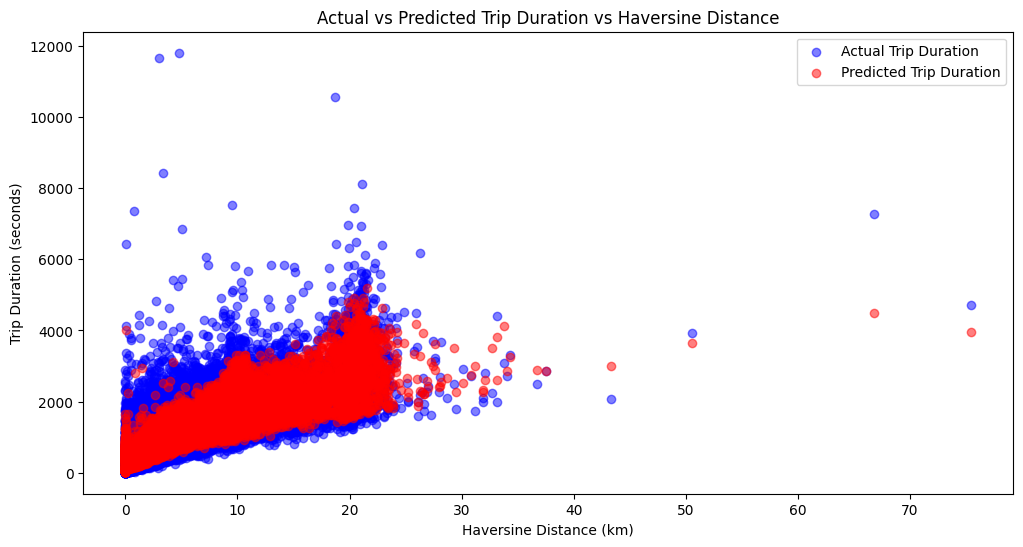

In [30]:
haversine_distances = X_valid['haversine_distance']

# Create a scatter plot for actual vs haversine distance
plt.figure(figsize=(12, 6))
plt.scatter(haversine_distances, y_valid, alpha=0.5, label='Actual Trip Duration', color='blue')
plt.scatter(haversine_distances, y_pred, alpha=0.5, label='Predicted Trip Duration', color='red')
plt.title("Actual vs Predicted Trip Duration vs Haversine Distance")
plt.xlabel("Haversine Distance (km)")
plt.ylabel("Trip Duration (seconds)")
plt.legend()
plt.show()

In [50]:
# Predict trip duration on the test set
test_predictions = model.predict(test_df[features])

# Prepare submission file
submission = pd.DataFrame({
    'id': test_df['id'],
    'trip_duration': test_predictions
})

# Save predictions
submission.to_csv('./data/submission1.csv', index=False)
print("Predictions saved to submission.csv!")


Predictions saved to submission.csv!
